In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [3]:


# Connect to the SQLite database
DB_PATH = '../moviematch/backend/src/database/movies.db'
conn = sqlite3.connect(DB_PATH)

# Read movies table into DataFrame 
movies_df = pd.read_sql_query("SELECT * FROM movies", conn)

print(f"Number of movies: {len(movies_df)}")

# Display first few rows
display(movies_df.head())

Number of movies: 131


,id,title,description,release_year,poster_url,genres,runtime_minutes,rating,embedding,watchmode_id,created_at,updated_at
0,1,A Minecraft Movie,Four misfits find themselves struggling with o...,2025,https://cdn.watchmode.com/posters/01687959_pos...,"[""Family"",""Comedy"",""Adventure"",""Fantasy""]",101.0,5.9,b'\xc2iz=\xb6\xf7{\xbc%\xdb\xca<\xdb\x13\x9c\x...,1687959,2025-06-01 01:49:26,2025-06-01 03:41:26
1,2,Final Destination Bloodlines,"Plagued by a violent recurring nightmare, coll...",2025,https://cdn.watchmode.com/posters/01567833_pos...,"[""Horror"",""Mystery""]",110.0,7.2,b'\xad\x98\xee\xbc\x87\xe5*\xbd\x8b\x08\xa1\xb...,1567833,2025-06-01 01:49:26,2025-06-01 03:41:26
2,3,Novocaine,"When the girl of his dreams is kidnapped, ever...",2025,https://cdn.watchmode.com/posters/01884650_pos...,"[""Action"",""Comedy"",""Thriller""]",110.0,6.7,b'\n|\x93\xbd\xce\xb1\xe6\xbc\x8aR@\xbd6\xba\x...,1884650,2025-06-01 01:49:26,2025-06-01 03:41:26
3,4,A Working Man,Levon Cade left behind a decorated military ca...,2025,https://cdn.watchmode.com/posters/01758068_pos...,"[""Action"",""Crime"",""Thriller""]",116.0,5.9,b'\xdf^\x06\xbe\xbc\x11C\xbc\x1fK\xd5\xbd\x10D...,1758068,2025-06-01 01:49:26,2025-06-01 03:41:27
4,5,Warfare,A platoon of Navy SEALs embarks on a dangerous...,2025,https://cdn.watchmode.com/posters/01788689_pos...,"[""War"",""Action""]",95.0,7.6,b'\x9fb\xb7<\x88\x17)\xbc\xdd\x89\x15\xbd+\xfc...,1788689,2025-06-01 01:49:26,2025-06-01 03:41:27


<Axes: xlabel='release_year'>

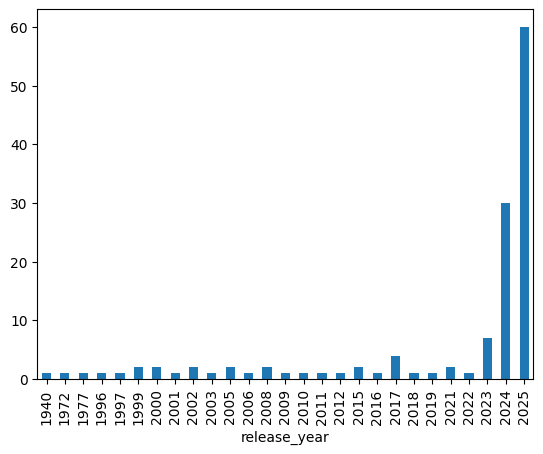

In [4]:
movies_df.groupby('release_year').size().plot(kind='bar')

In [5]:
# Filter for movies before 2023
old_movies = movies_df[movies_df['release_year'] < 2023]

print(f"\nMovies before 2023: {len(old_movies)}")
display(old_movies[['title', 'release_year', 'rating']].sort_values('release_year', ascending=False))



Movies before 2023: 34


,title,release_year,rating
116,MK Ultra,2022,5.2
119,Pleasure,2021,6.2
94,Ron's Gone Wrong,2021,7.3
79,Parasite,2019,8.6
96,Avengers: Infinity War,2018,8.5
120,Gerald's Game,2017,6.6
91,Spider-Man: Homecoming,2017,7.6
56,Wind River,2017,7.8
48,Wonder Woman,2017,7.5
130,The Accountant,2016,7.5


In [6]:

def find_similar_movies(title, df=movies_df, n=5):
    """
    Find most similar movies to a given title based on embedding similarity.
    
    Args:
        title (str): Title of the movie to find similarities for
        df (DataFrame): DataFrame containing movie data
        n (int): Number of similar movies to return
    """
    # Find the movie in the dataframe
    movie = df[df['title'] == title]
    if len(movie) == 0:
        print(f"Movie '{title}' not found in database")
        return
        
    # Get the embedding for our target movie
    target_embedding = np.frombuffer(movie.iloc[0]['embedding'], dtype=np.float32)
    
    # Calculate similarities with all other movies
    similarities = []
    for idx, row in df.iterrows():
        if row['title'] != title:  # Skip comparing with itself
            emb = np.frombuffer(row['embedding'], dtype=np.float32)
            # Calculate cosine similarity
            similarity = np.dot(target_embedding, emb) / (np.linalg.norm(target_embedding) * np.linalg.norm(emb))            
            similarities.append((row['title'], similarity, row['release_year'], row['rating']))
    
    # Sort by similarity and get top N
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nMost similar movies to '{title}':")
    print("\nTitle | Release Year | Rating | Similarity Score")
    print("-" * 60)
    for movie_title, sim, year, rating in similarities[:n]:
        print(f"{movie_title} ({year}) | Rating: {rating:.1f} | Similarity: {sim:.3f}")

# Example usage
find_similar_movies("The Matrix")
find_similar_movies("How to Train Your Dragon")




Most similar movies to 'The Matrix':

Title | Release Year | Rating | Similarity Score
------------------------------------------------------------
A Working Man (2025) | Rating: 5.9 | Similarity: 0.447
Havoc (2025) | Rating: 5.6 | Similarity: 0.390
The Gorge (2025) | Rating: 6.9 | Similarity: 0.383
Mission: Impossible II (2000) | Rating: 5.9 | Similarity: 0.372
Fight or Flight (2024) | Rating: 6.6 | Similarity: 0.363

Most similar movies to 'How to Train Your Dragon':

Title | Release Year | Rating | Similarity Score
------------------------------------------------------------
The Lord of the Rings: The War of the Rohirrim (2024) | Rating: 6.5 | Similarity: 0.433
Shrek (2001) | Rating: 8.0 | Similarity: 0.421
Panda Bear in Africa (2024) | Rating: 5.7 | Similarity: 0.377
Plankton: The Movie (2025) | Rating: 5.5 | Similarity: 0.315
Death of a Unicorn (2025) | Rating: 6.1 | Similarity: 0.314


In [19]:
# Get details for specific movies
movies_to_check = ["The Matrix", "How to Train Your Dragon", "Apocalypse Z: The Beginning of the End"]

print("Movie Details:\n")
for title in movies_to_check:
    movie = movies_df[movies_df['title'] == title]
    if len(movie) > 0:
        print(f"Title: {movie.iloc[0]['title']}")
        print(f"Description: {movie.iloc[0]['description']}")
        print(f"Genres: {movie.iloc[0]['genres']}")
        print("\n")
    else:
        print(f"Movie '{title}' not found in database\n")


Movie Details:

Title: The Matrix
Description: Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.
Genres: ["Action","Science Fiction"]


Title: How to Train Your Dragon
Description: As the son of a Viking leader on the cusp of manhood, shy Hiccup Horrendous Haddock III faces a rite of passage: he must kill a dragon to prove his warrior mettle. But after downing a feared dragon, he realizes that he no longer wants to destroy it, and instead befriends the beast – which he names Toothless – much to the chagrin of his warrior father.
Genres: ["Fantasy","Adventure","Animation","Family"]


Title: Apocalypse Z: The Beginning of the End
Description: When a kind of rabies that transforms people into aggressive creatures spreads across the planet, Manel isolates himself at home with his cat, relying on his wits to survive; but soon they must go out in search of food,

Cosine similarity between The Lord of the Rings: The War of the Rohirrim and How to Train Your Dragon: 0.4335


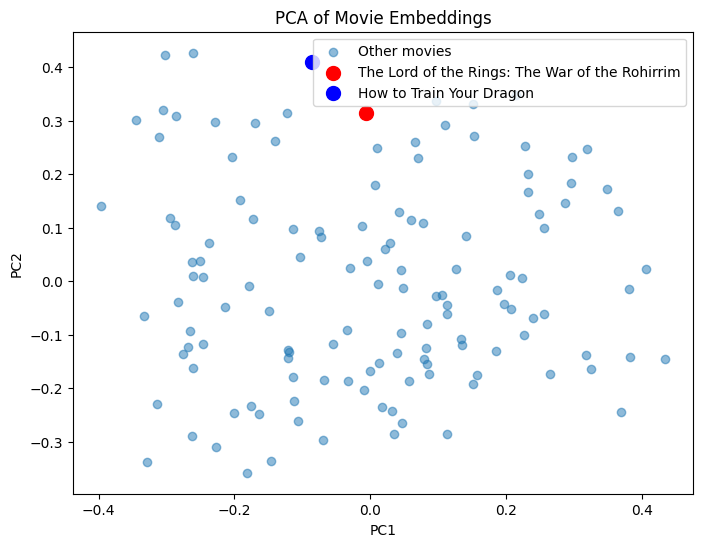


The Lord of the Rings: The War of the Rohirrim:
Genres: ["Animation","Fantasy","Adventure","Action"]
Description: A sudden attack by Wulf, a clever and traitorous lord of Rohan seeking vengeance for the death of his father, forces Helm Hammerhand, the King of Rohan, and his people to make a daring last stand in the ancient stronghold of the Hornburg.

How to Train Your Dragon:
Genres: ["Fantasy","Adventure","Animation","Family"]
Description: As the son of a Viking leader on the cusp of manhood, shy Hiccup Horrendous Haddock III faces a rite of passage: he must kill a dragon to prove his warrior mettle. But after downing a feared dragon, he realizes that he no longer wants to destroy it, and instead befriends the beast – which he names Toothless – much to the chagrin of his warrior father.


In [8]:
# --- New Analysis: Understanding Movie Embedding Similarity ---
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Print the embeddings for 'The Matrix' and 'How to Train Your Dragon'

movie1 = 'The Lord of the Rings: The War of the Rohirrim'
movie2 = 'How to Train Your Dragon'
movie1_row = movies_df[movies_df['title'] == movie1].iloc[0]
movie2_row = movies_df[movies_df['title'] == movie2].iloc[0]
movie1_emb = np.frombuffer(movie1_row['embedding'], dtype=np.float32)
movie2_emb = np.frombuffer(movie2_row['embedding'], dtype=np.float32)

#print('Embedding for The Matrix:', movie1_emb)
#print('Embedding for How to Train Your Dragon:', movie2_emb)

# 2. Calculate and print their cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

sim = cosine_similarity(movie1_emb, movie2_emb)
print(f'Cosine similarity between {movie1} and {movie2}: {sim:.4f}')

# 3. Visualize the embeddings with PCA (for all movies, highlight these two)
embeddings = np.stack([np.frombuffer(row['embedding'], dtype=np.float32) for _, row in movies_df.iterrows()])
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.5, label='Other movies')

# Highlight the two movies
movie1_idx = movies_df[movies_df['title'] == movie1].index[0]
movie2_idx = movies_df[movies_df['title'] == movie2].index[0]
plt.scatter(embeddings_2d[movie1_idx,0], embeddings_2d[movie1_idx,1], color='red', label=movie1, s=100)
plt.scatter(embeddings_2d[movie2_idx,0], embeddings_2d[movie2_idx,1], color='blue', label=movie2, s=100)
plt.legend()
plt.title('PCA of Movie Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 4. Compare genres and descriptions
print(f'\n{movie1}:')
print('Genres:', movie1_row['genres'])
print('Description:', movie1_row['description'])
print(f'\n{movie2}:')
print('Genres:', movie2_row['genres'])
print('Description:', movie2_row['description'])

In [9]:
# Calculate average similarity between movies of same genres
genre_similarities = {}
genre_counts = {}

# First get all unique genres
all_genres = set()
for genres_str in movies_df['genres']:
    genres = eval(genres_str)  # Convert string representation of list to actual list
    all_genres.update(genres)

# Calculate similarities between all movies sharing each genre
for genre in all_genres:
    # Get all movies with this genre
    genre_movies = movies_df[movies_df['genres'].apply(lambda x: genre in eval(x))]
    
    if len(genre_movies) < 2:  # Skip if less than 2 movies in genre
        continue
        
    # Calculate average similarity between all pairs of movies in this genre
    similarities = []
    movies_list = list(genre_movies.iterrows())
    
    for i in range(len(movies_list)):
        for j in range(i+1, len(movies_list)):
            movie1 = movies_list[i][1]
            movie2 = movies_list[j][1]
            
            emb1 = np.frombuffer(movie1['embedding'], dtype=np.float32)
            emb2 = np.frombuffer(movie2['embedding'], dtype=np.float32)
            
            sim = cosine_similarity(emb1, emb2)
            similarities.append(sim)
    
    avg_similarity = np.mean(similarities)
    genre_similarities[genre] = avg_similarity
    genre_counts[genre] = len(genre_movies)

# Sort genres by similarity
sorted_genres = sorted(genre_similarities.items(), key=lambda x: x[1], reverse=True)

# Print results
print("\nAverage similarity between movies in each genre:")
print("\nGenre | Avg Similarity | Number of Movies")
print("-" * 45)
for genre, similarity in sorted_genres:
    print(f"{genre:<15} | {similarity:.4f} | {genre_counts[genre]:>3} movies")




Average similarity between movies in each genre:

Genre | Avg Similarity | Number of Movies
---------------------------------------------
War             | 0.3468 |   4 movies
Western         | 0.3276 |   3 movies
Horror          | 0.3188 |  24 movies
Mystery         | 0.2939 |  15 movies
Animation       | 0.2819 |  14 movies
Crime           | 0.2801 |  17 movies
Family          | 0.2761 |  15 movies
Science Fiction | 0.2681 |  20 movies
Fantasy         | 0.2663 |  20 movies
Thriller        | 0.2615 |  50 movies
Comedy          | 0.2534 |  26 movies
Action          | 0.2420 |  61 movies
Romance         | 0.2336 |   9 movies
Adventure       | 0.2261 |  38 movies
History         | 0.2070 |   3 movies
Drama           | 0.1671 |  29 movies


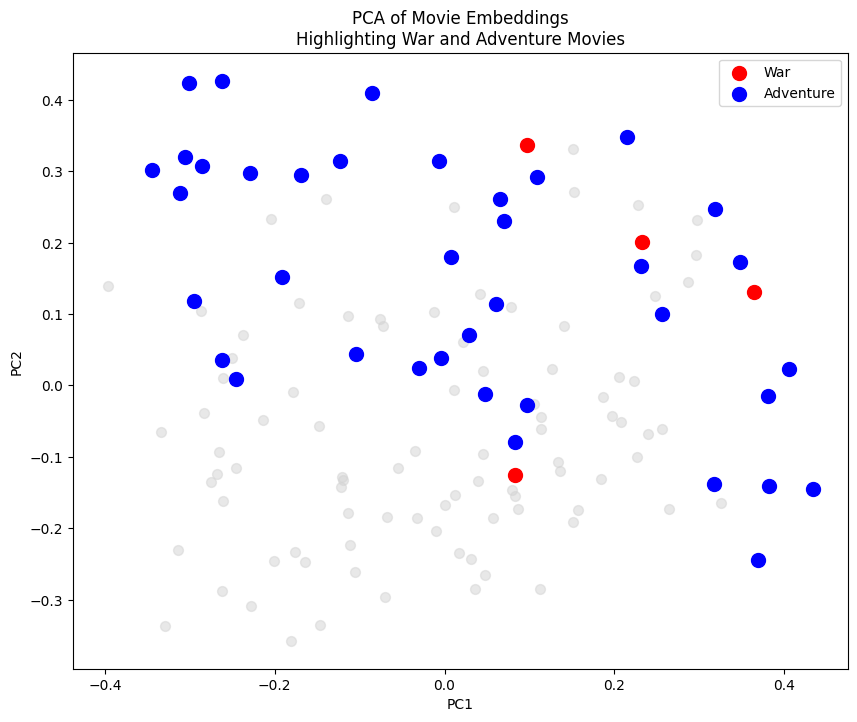


Number of War movies: 4
Average similarity between War movies: 0.3468

Number of Adventure movies: 38
Average similarity between Adventure movies: 0.2261


In [10]:
# Select two genres to highlight
genre1 = "War"
genre2 = "Adventure"

# Create PCA plot with genre highlighting
plt.figure(figsize=(10,8))

# Plot all movies in gray first
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], color='lightgray', alpha=0.5, s=50)

# Highlight movies from first genre in red
genre1_mask = movies_df['genres'].apply(lambda x: genre1 in eval(x))
genre1_movies_indices = movies_df[genre1_mask].index
plt.scatter(embeddings_2d[genre1_movies_indices,0], embeddings_2d[genre1_movies_indices,1], 
           color='red', label=genre1, s=100)

# Highlight movies from second genre in blue
genre2_mask = movies_df['genres'].apply(lambda x: genre2 in eval(x))
genre2_movies_indices = movies_df[genre2_mask].index
plt.scatter(embeddings_2d[genre2_movies_indices,0], embeddings_2d[genre2_movies_indices,1],
           color='blue', label=genre2, s=100)

plt.title(f'PCA of Movie Embeddings\nHighlighting {genre1} and {genre2} Movies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Print some stats about both highlighted genres
print(f"\nNumber of {genre1} movies: {len(genre1_movies_indices)}")
print(f"Average similarity between {genre1} movies: {genre_similarities[genre1]:.4f}")
print(f"\nNumber of {genre2} movies: {len(genre2_movies_indices)}")
print(f"Average similarity between {genre2} movies: {genre_similarities[genre2]:.4f}")


In [22]:
# Interactive PCA plot with Plotly highlighting two genres
import plotly.express as px

# Select two genres to highlight
genre1 = "Horror"
genre2 = "Comedy"

# Prepare DataFrame for plotly
pca_df = movies_df.copy()
pca_df['PC1'] = embeddings_2d[:,0]
pca_df['PC2'] = embeddings_2d[:,1]
pca_df['genres_eval'] = pca_df['genres'].apply(eval)

# Calculate medians for quadrant lines
pc1_median = pca_df['PC1'].median()
pc2_median = pca_df['PC2'].median()

# Assign color labels
pca_df['highlight'] = 'Other'
pca_df.loc[pca_df['genres_eval'].apply(lambda x: genre1 in x), 'highlight'] = genre1
pca_df.loc[pca_df['genres_eval'].apply(lambda x: genre2 in x), 'highlight'] = genre2

# Plotly scatter plot
fig = px.scatter(
    pca_df, x='PC1', y='PC2',
    color='highlight',
    color_discrete_map={genre1: 'red', genre2: 'blue', 'Other': 'lightgray'},
     title=f'PCA of Movie Embeddings (Highlighting {genre1} and {genre2} Movies)',
     hover_data=['title', 'rating', 'genres']
)

# Add quadrant lines
fig.add_hline(y=pc2_median, line_dash="dash", line_color="gray")
fig.add_vline(x=pc1_median, line_dash="dash", line_color="gray")

fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.show()

# Print stats about both highlighted genres
print(f"\nNumber of {genre1} movies: {len(pca_df[pca_df['highlight'] == genre1])}")
print(f"Average similarity between {genre1} movies: {genre_similarities[genre1]:.4f}")
print(f"\nNumber of {genre2} movies: {len(pca_df[pca_df['highlight'] == genre2])}")
print(f"Average similarity between {genre2} movies: {genre_similarities[genre2]:.4f}")



Number of Horror movies: 21
Average similarity between Horror movies: 0.3188

Number of Comedy movies: 26
Average similarity between Comedy movies: 0.2534


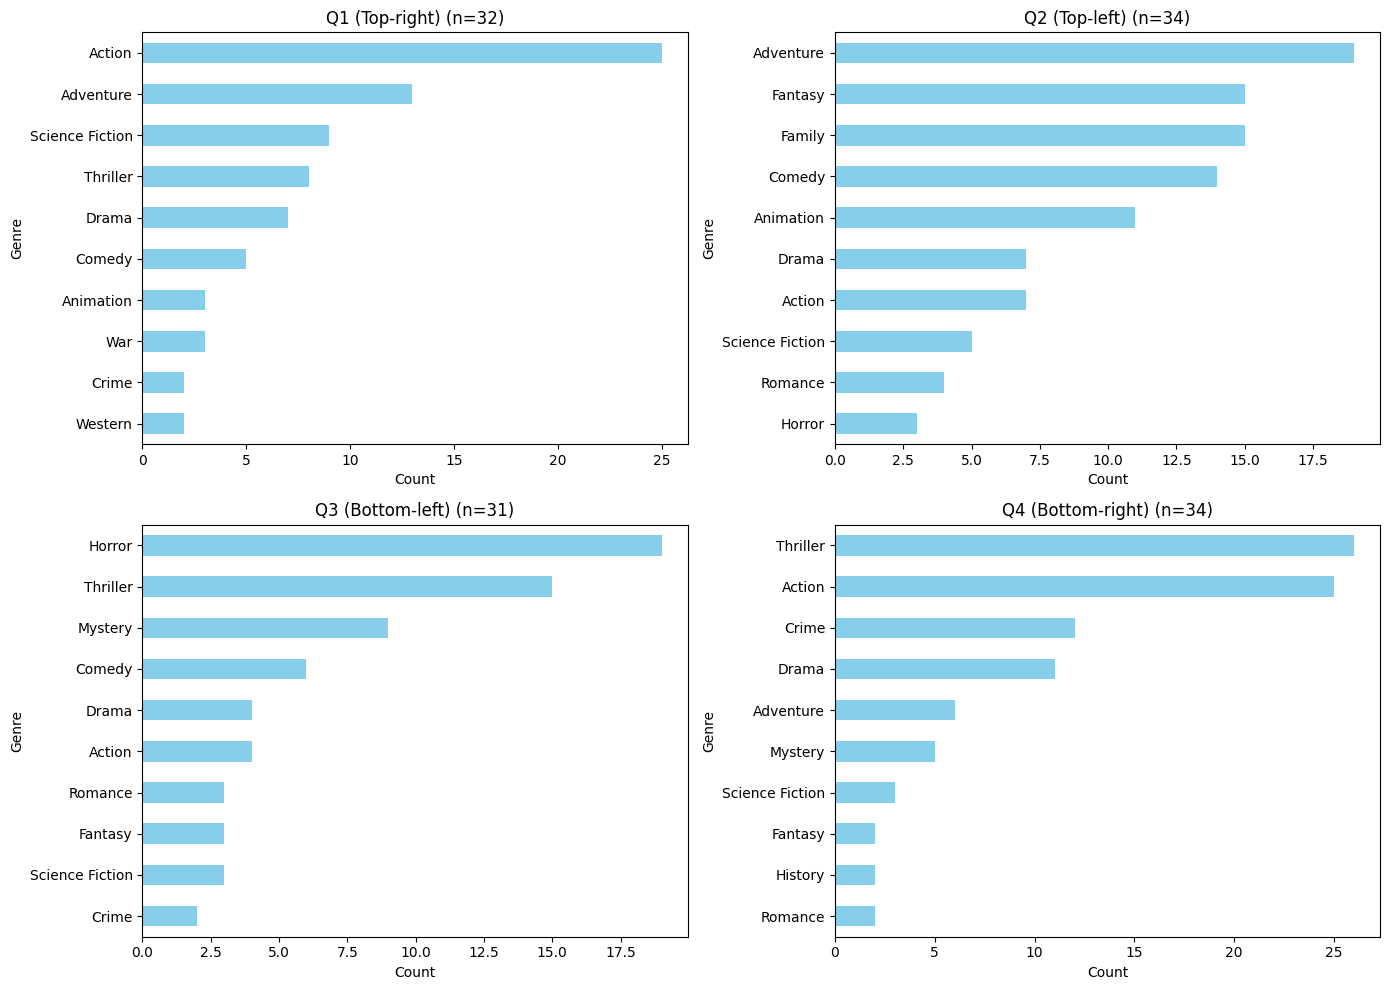

<Figure size 1400x1000 with 0 Axes>

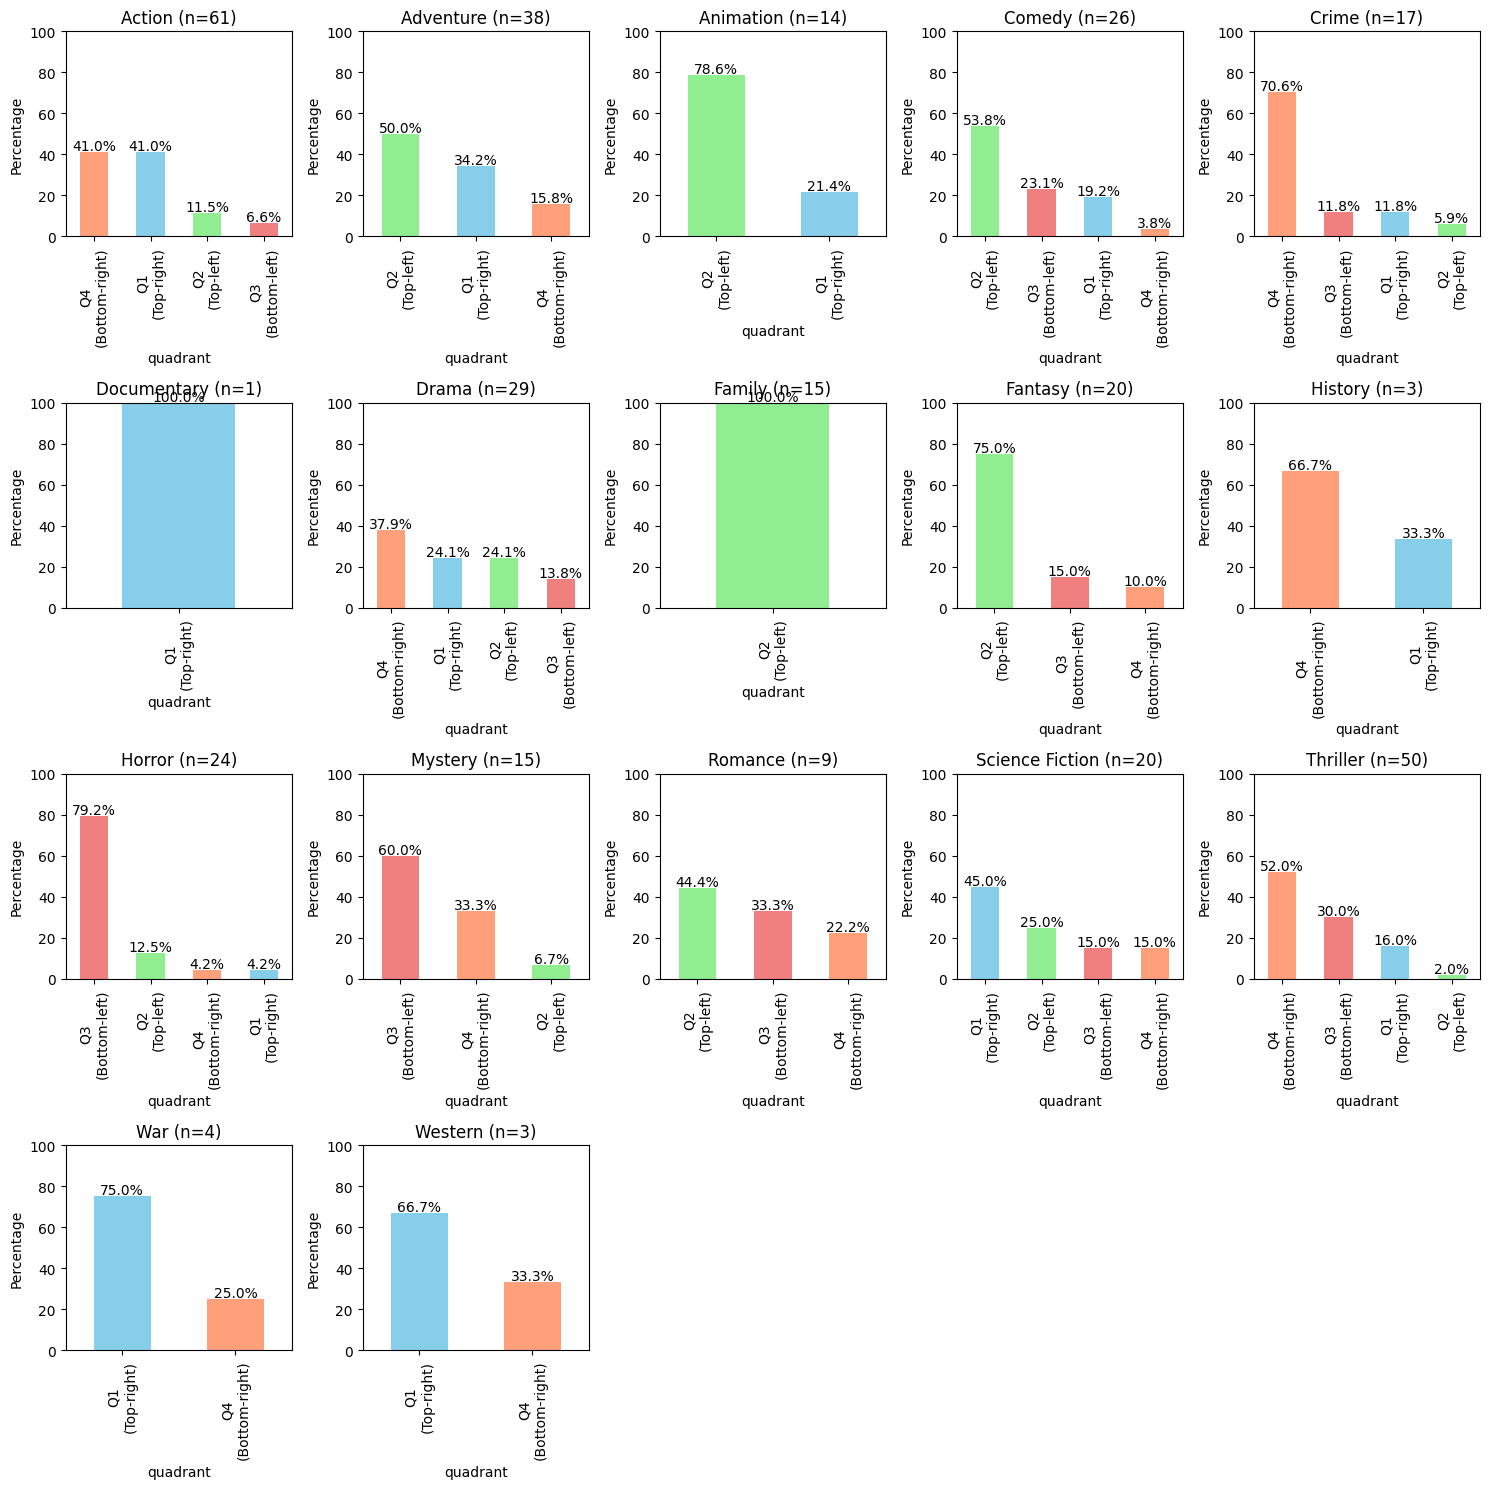

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pca_df is already defined as before, with 'PC1', 'PC2', and 'genres_eval'

# Define quadrant boundaries
pc1_median = pca_df['PC1'].median()
pc2_median = pca_df['PC2'].median()

def assign_quadrant(row):
    if row['PC1'] >= pc1_median and row['PC2'] >= pc2_median:
        return 'Q1'  # Top-right
    elif row['PC1'] < pc1_median and row['PC2'] >= pc2_median:
        return 'Q2'  # Top-left
    elif row['PC1'] < pc1_median and row['PC2'] < pc2_median:
        return 'Q3'  # Bottom-left
    else:
        return 'Q4'  # Bottom-right

pca_df['quadrant'] = pca_df.apply(assign_quadrant, axis=1)

# Prepare the data for each quadrant
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
quadrants = ['Q1', 'Q2', 'Q3', 'Q4']
titles = {
    'Q1': 'Q1 (Top-right)',
    'Q2': 'Q2 (Top-left)',
    'Q3': 'Q3 (Bottom-left)',
    'Q4': 'Q4 (Bottom-right)'
}

for i, q in enumerate(quadrants):
    quad_df = pca_df[pca_df['quadrant'] == q]
    all_genres = [genre for genres in quad_df['genres_eval'] for genre in genres]
    genre_counts = pd.Series(all_genres).value_counts().head(10)
    ax = axes[i // 2, i % 2]
    genre_counts.sort_values().plot.barh(ax=ax, color='skyblue')
    ax.set_title(f"{titles[q]} (n={len(quad_df)})")
    ax.set_xlabel('Count')
    ax.set_ylabel('Genre')

plt.tight_layout()
plt.show()


# ------

# Create a plot showing genre distribution across quadrants
plt.figure(figsize=(14, 10))

# Get all unique genres
all_genres = set()
for genres in pca_df['genres_eval']:
    all_genres.update(genres)

# Sort genres alphabetically for consistent plotting
all_genres = sorted(list(all_genres))

# Calculate number of subplots needed (aim for roughly square layout)
n_genres = len(all_genres)
n_cols = int(np.ceil(np.sqrt(n_genres)))
n_rows = int(np.ceil(n_genres / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Create a mapping of quadrants to their locations
quadrant_locations = {
    'Q1': 'Top-right',
    'Q2': 'Top-left', 
    'Q3': 'Bottom-left',
    'Q4': 'Bottom-right'
}

# Define consistent colors for quadrants
quadrant_colors = {
    'Q1': 'skyblue',
    'Q2': 'lightgreen', 
    'Q3': 'lightcoral',
    'Q4': 'lightsalmon'
}

# For each genre, create a subplot showing quadrant distribution
for idx, genre in enumerate(all_genres):
    # Get movies with this genre
    genre_movies = pca_df[pca_df['genres_eval'].apply(lambda x: genre in x)]
    
    # Calculate quadrant distribution
    quad_dist = genre_movies['quadrant'].value_counts()
    
    # Calculate percentages
    quad_pcts = (quad_dist / len(genre_movies) * 100).round(1)
    
    # Plot
    ax = axes[idx]
    quad_pcts.plot(kind='bar', ax=ax, color=[quadrant_colors[q] for q in quad_pcts.index])
    ax.set_title(f'{genre} (n={len(genre_movies)})')
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 100)
    
    # Add percentage labels on bars
    for i, v in enumerate(quad_pcts):
        ax.text(i, v + 1, f'{v}%', ha='center')
    
    # Update x-axis labels to include quadrant locations
    x_labels = [f'{q}\n({quadrant_locations[q]})' for q in quad_pcts.index]
    ax.set_xticklabels(x_labels)

# Remove empty subplots if any
for idx in range(len(all_genres), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [15]:
def describe_quadrant(genre_counts, n_movies, quadrant_name=""):
    """
    genre_counts: pd.Series of genre counts (sorted, e.g. from value_counts())
    n_movies: int, number of movies in the quadrant
    quadrant_name: str, e.g. 'Q1'
    """
    top = genre_counts.head(5)
    if len(top) == 0:
        return f"{quadrant_name}: No movies in this quadrant."
    elif len(top) == 1:
        desc = f"mostly {top.index[0]}"
    elif len(top) == 2:
        desc = f"mostly {top.index[0]} and {top.index[1]}"
    else:
        desc = f"mostly {top.index[0]}, {top.index[1]}, and {top.index[2]}"
    percent = (top / n_movies * 100).round(1)
    details = ", ".join([f"{g} ({percent[g]}%)" for g in top.index])
    return (
        f"{quadrant_name} ({n_movies} movies): This quadrant contains {desc} movies. "
        f"Top genres: {details}."
    )

# Example usage inside your loop:
for q in quadrants:
    quad_df = pca_df[pca_df['quadrant'] == q]
    all_genres = [genre for genres in quad_df['genres_eval'] for genre in genres]
    genre_counts = pd.Series(all_genres).value_counts()
    print(describe_quadrant(genre_counts, len(quad_df), quadrant_name=q))

Q1 (32 movies): This quadrant contains mostly Action, Adventure, and Science Fiction movies. Top genres: Action (78.1%), Adventure (40.6%), Science Fiction (28.1%), Thriller (25.0%), Drama (21.9%).
Q2 (34 movies): This quadrant contains mostly Adventure, Family, and Fantasy movies. Top genres: Adventure (55.9%), Family (44.1%), Fantasy (44.1%), Comedy (41.2%), Animation (32.4%).
Q3 (31 movies): This quadrant contains mostly Horror, Thriller, and Mystery movies. Top genres: Horror (61.3%), Thriller (48.4%), Mystery (29.0%), Comedy (19.4%), Action (12.9%).
Q4 (34 movies): This quadrant contains mostly Thriller, Action, and Crime movies. Top genres: Thriller (76.5%), Action (73.5%), Crime (35.3%), Drama (32.4%), Adventure (17.6%).


In [21]:
# Filter and display movies containing "Apocalypse Z" in the title
apocalypse_movies = pca_df[pca_df['title'].str.contains('Apocalypse Z', case=False, na=False)]
if len(apocalypse_movies) > 0:
    print("\nMovies containing 'Apocalypse Z':")
    print("--------------------------------")
    for _, movie in apocalypse_movies.iterrows():
        print("\nTitle:", movie['title'])
        print("Description:", movie['description'])
        print("Genres:", movie['genres_eval'])
        print("Rating:", movie['rating'])
        print("Release Year:", movie['release_year'])
        print("--------------------------------")
else:
    print("\nNo movies found containing 'Apocalypse Z' in the title")




Movies containing 'Apocalypse Z':
--------------------------------

Title: Apocalypse Z: The Beginning of the End
Description: When a kind of rabies that transforms people into aggressive creatures spreads across the planet, Manel isolates himself at home with his cat, relying on his wits to survive; but soon they must go out in search of food, by land and by sea, dodging many dangers.
Genres: ['Drama', 'Action', 'Horror']
Rating: 6.3
Release Year: 2024
--------------------------------
